## Setting Environment

In [1]:
!pip install pandas
!pip install matplotlib
!pip install scikit-learn==1.3.0
!pip install torch
!pip install torchvision
!pip install seaborn
!pip install numpy
!pip install opencv-python
!pip install scikit-image
!pip install tqdm
!pip install joblib
!pip install scipy
!pip install imbalanced-learn

!mkdir ./data/pickles
!python3 ./src/data/augment_data.py
!python3 ./src/data/preprocessing/preprocess.py

mkdir: ./data/pickles: File exists


## Imports

In [2]:
import os
import requests
import pickle as pk
from io import BytesIO
import seaborn as sns

import numpy as np
import pandas as pd
from IPython.display import Image, display
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from src.data.elpv_reader import load_dataset
from src.data.preprocessing.mobilenetv2 import get_processed_data_loaders
from src.data.preprocessing.preprocess import Preprocess
from src.models.mobilenetv2.model_with_mobilenetv2_and_Kmeans import (
    get_solar_cell_defect_detector,
)
import cv2
from src.models.mobilenetv2.testing import evaluate_detector_on_test_data
from src.utils.results_helper import map_label_to_probability
from src.visualization.visualize import (
    show_image,
    show_metrics,
    visualize_images_by_type_and_proba,
)
from src.visualization.visualize_results import plot_metrics

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import random

## Visualising images in the dataset for the combination of type and probability

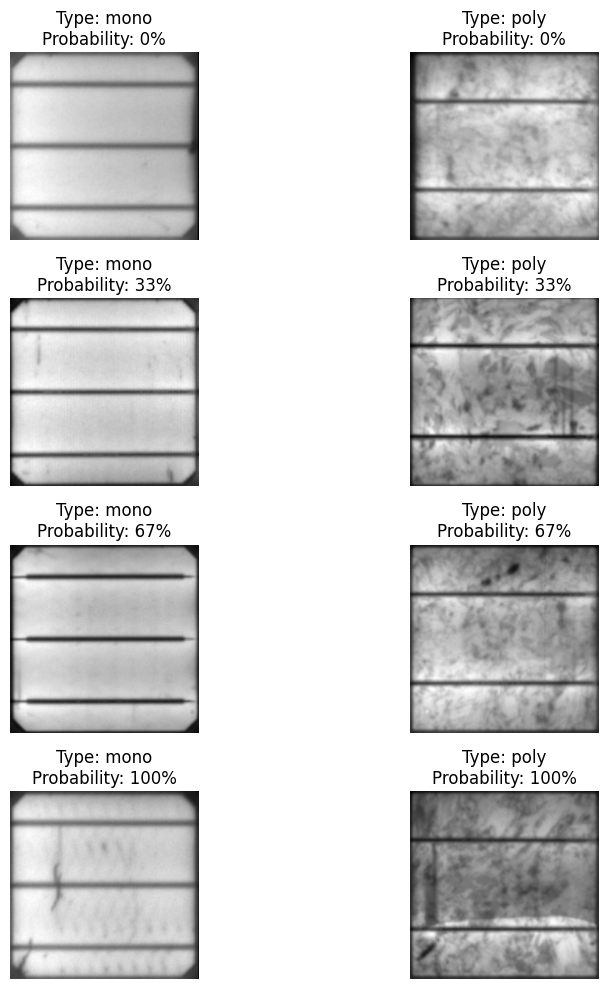

In [3]:
images, probs, types = load_dataset()
visualize_images_by_type_and_proba(images, probs, types)
metrics = dict()
model_name = "mobilenetv2"
load_objects = True ## this one makes sure that saved model weights are loaded for each model, switching this to False will start the training loop again for all the 3 cases of training

## Model: MobileNetv2 with Kmeans classifier

The proposed approach consists of two phases.

The first phase is based on MobileNetv2 and Kmeans. This phase’s objective was to perform data training. It finds the clusters of solar cells, constructs a detection model that can identify the defective solar cell for each cluster of cells and builds a classifier model of the solar cell image of the constructed clusters, which helps overcome the confusion between the different cell shapes and increases the detection accuracy.

The second phase uses the constructed Kmeans classifier to classify the cell image to the cluster label that has the closest set of solar images. Then, it uses the assigned cluster’s constructed detection model to identify the defective solar cell.

The flow looks like this

<img src="data/model_architectures/mobilenetv2_with_kmeans_flow.png" width="1000" height="300">


__The first phase is the training phase and is as follows__

__Model1__: This is a modified MobileNetV2 model. The first convolutional layer is adapted to accept single-channel (greyscale) input images, and the final classification layer is replaced with a new one that outputs four classes. We use the weights MobileNet_V2_Weights.DEFAULT as starting weights for our model1 to be trained on.

<img src="data/model_architectures/model1.png" width="1000" height="300">

where Conv2D is the 2D convolution layer, avgpool is the average pooling layer, FC is the fully connected layer, and BMV2 is the block of MobileNetV2, Each BMV2 can be repeated n times with stride s and an expansion factor t.
The training phase aims to update all training parameter values 2,228,420 parameters of Model 1 layers to fit the training data by minimizing the difference value between the actual class label of image and the predicted label during the training process.

__FeatureExtractor__: This class is a wrapper around the Model1 instance, designed to extract features from images. It removes the final classification layer from Model1 and flattens the output features for further processing.

__Kmeans__: We try to create 8 clusters of features derived from FeatureExtractor.

__Model2__: This class represents a model architecture that receives feature vectors from FeatureExtractor. It has a layer to reduce the dimensionality of the input features and a classification layer to predict the class for each feature vector. We train 8 instances of model2, each instance specific for our classified cluster. This step is used to overcome the confusion in detecting solar cracks resulting from the different characteristics of solar cell shapes.

<img src="data/model_architectures/model2.png" width="1000" height="300">

This process aims to update the additional training parameter values ‘‘164,097 parameters’’ of Model 2’s new layer, which freezes the other layers’ parameter values in the training process. Model 2 will be trained K times to construct K classifiers, one classifier for each cluster. To fit the training cell images for cluster I, the additional training parameter values of Ci classifier will be updated. Each cluster contains a set of cell images with high similarity of the structure shape, ensuring that the different structure shapes of solar cells are not confused. The updated process of the additional training parameters will be focused on distinct defective and nondefective solar cells of a specific cluster without considering the different cell structures of other clusters.

__SolarCellDefectDetector__: This class integrates the whole system. It uses Model1 for feature extraction, a k-means clustering algorithm to assign each image to a cluster, and then uses the corresponding Model2 instance for the final classification.

__The second phase is the detection phase and it as follows__

The __detect_defect__ method in the __SolarCellDefectDetector__ class performs the following steps:

- Sets Model1 to evaluation mode.
- Creates a FeatureExtractor instance and processes the input image to extract features.
- Predicts the cluster ID for the extracted features using k-means.
- Selects the corresponding Model2 instance based on the predicted cluster ID, sets it to evaluation mode, and uses it to classify the image.
- Returns the predicted class.


### Both

In [4]:
(
    train_loader,
    val_loader,
    test_loader,
    train_dataset,
    val_dataset,
) = get_processed_data_loaders("both", load_data=load_objects)
solar_cell_detector_both = get_solar_cell_defect_detector(
    train_loader,
    val_loader,
    train_dataset,
    val_dataset,
    "data_both",
    load_weights=load_objects,
)
(
    metrics[("both", 224, "data")],
    correct_classification_both,
    incorrect_classification_both,
) = evaluate_detector_on_test_data(
    solar_cell_detector_both, test_loader, "data_both", load_results=load_objects
)

data loaders loaded
Weights loaded for model 1 from the file:  /Users/dipankarsrirag/Desktop/UNSW/2023/Term 3/COMP9517/Project/src/features/mobilenetv2/data_both/model1/model_1_weights.pth
kmeans model loaded from :  /Users/dipankarsrirag/Desktop/UNSW/2023/Term 3/COMP9517/Project/src/features/mobilenetv2/data_both/kmeans/kmeans.pkl
Model for cluster 0 loaded from /Users/dipankarsrirag/Desktop/UNSW/2023/Term 3/COMP9517/Project/src/features/mobilenetv2/data_both/model2/model2_cluster_0.pth
Model for cluster 1 loaded from /Users/dipankarsrirag/Desktop/UNSW/2023/Term 3/COMP9517/Project/src/features/mobilenetv2/data_both/model2/model2_cluster_1.pth
Model for cluster 2 loaded from /Users/dipankarsrirag/Desktop/UNSW/2023/Term 3/COMP9517/Project/src/features/mobilenetv2/data_both/model2/model2_cluster_2.pth
Model for cluster 3 loaded from /Users/dipankarsrirag/Desktop/UNSW/2023/Term 3/COMP9517/Project/src/features/mobilenetv2/data_both/model2/model2_cluster_3.pth
Model for cluster 4 loaded fro

**Metrics for the model**

Accuracy:  0.9068441064638784
F1 score:  0.9054460086609685
Confusion matrix: 


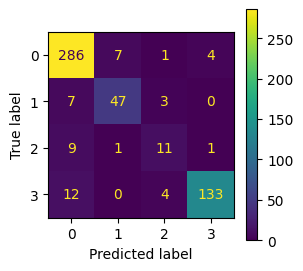

In [5]:
show_metrics(metrics[("both", 224, "data")])

#### An example of correct classifcation by the model

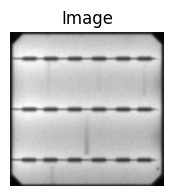

predicted class:  possibly defective (33% probability)
actual class:  possibly defective (33% probability)


In [6]:
show_image(correct_classification_both[0], title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(solar_cell_detector_both.detect_defect(correct_classification_both[0]))}\n" +
    f"actual class: {map_label_to_probability(correct_classification_both[1])}"
)

#### An example of misclassifcation by the model

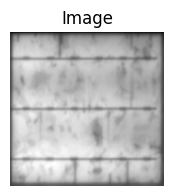

predicted class:  possibly defective (33% probability)
actual class: fully functional (0% probability of being defective)


In [7]:
show_image(incorrect_classification_both[0], title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(solar_cell_detector_both.detect_defect(incorrect_classification_both[0]))}\n" +
    f"actual class: {map_label_to_probability(incorrect_classification_both[1])}"
)

### Monocrystallline Solar Cell

In [8]:
(
    train_loader,
    val_loader,
    test_loader,
    train_dataset,
    val_dataset,
) = get_processed_data_loaders("mono", load_data=load_objects)
solar_cell_detector_mono = get_solar_cell_defect_detector(
    train_loader,
    val_loader,
    train_dataset,
    val_dataset,
    "data_mono",
    load_weights=load_objects,
)
(
    metrics[("mono", 224, "data")],
    correct_classification_mono,
    incorrect_classification_mono,
) = evaluate_detector_on_test_data(
    solar_cell_detector_mono, test_loader, "data_mono", load_results=load_objects
)

data loaders loaded
Weights loaded for model 1 from the file:  /Users/dipankarsrirag/Desktop/UNSW/2023/Term 3/COMP9517/Project/src/features/mobilenetv2/data_mono/model1/model_1_weights.pth
kmeans model loaded from :  /Users/dipankarsrirag/Desktop/UNSW/2023/Term 3/COMP9517/Project/src/features/mobilenetv2/data_mono/kmeans/kmeans.pkl
Model for cluster 0 loaded from /Users/dipankarsrirag/Desktop/UNSW/2023/Term 3/COMP9517/Project/src/features/mobilenetv2/data_mono/model2/model2_cluster_0.pth
Model for cluster 1 loaded from /Users/dipankarsrirag/Desktop/UNSW/2023/Term 3/COMP9517/Project/src/features/mobilenetv2/data_mono/model2/model2_cluster_1.pth
Model for cluster 2 loaded from /Users/dipankarsrirag/Desktop/UNSW/2023/Term 3/COMP9517/Project/src/features/mobilenetv2/data_mono/model2/model2_cluster_2.pth
Model for cluster 3 loaded from /Users/dipankarsrirag/Desktop/UNSW/2023/Term 3/COMP9517/Project/src/features/mobilenetv2/data_mono/model2/model2_cluster_3.pth
Model for cluster 4 loaded fro

**Metrics for the model**

Accuracy:  0.9209302325581395
F1 score:  0.9198877735589329
Confusion matrix: 


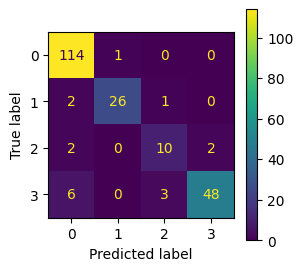

In [9]:
show_metrics(metrics[("mono", 224, "data")])

#### An example of correct classifcation by the model

correct classification by the model: 


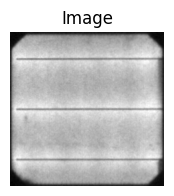

predicted class: fully functional (0% probability of being defective)
actual class: fully functional (0% probability of being defective)


In [10]:
print("correct classification by the model: ")
show_image(correct_classification_mono[0], title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(solar_cell_detector_mono.detect_defect(correct_classification_mono[0]))}\n" +
    f"actual class: {map_label_to_probability(correct_classification_mono[1])}"
)

#### An example of misclassifcation by the model

misclassification by the model: 


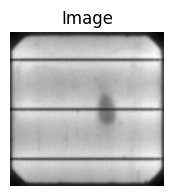

predicted class: likely defective (67% probability)
actual class: certainly defective (100% probability)


In [11]:
print("misclassification by the model: ")
show_image(incorrect_classification_mono[0], title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(solar_cell_detector_mono.detect_defect(incorrect_classification_mono[0]))}\n" +
    f"actual class: {map_label_to_probability(incorrect_classification_mono[1])}"
)

### Polycrystalline Solar Cell

In [12]:
(
    train_loader,
    val_loader,
    test_loader,
    train_dataset,
    val_dataset,
) = get_processed_data_loaders("poly", load_data=load_objects)
solar_cell_detector_poly = get_solar_cell_defect_detector(
    train_loader,
    val_loader,
    train_dataset,
    val_dataset,
    "data_poly",
    load_weights=load_objects,
)
(
    metrics[("poly", 224, "data")],
    correct_classification_poly,
    incorrect_classification_poly,
) = evaluate_detector_on_test_data(
    solar_cell_detector_poly, test_loader, "data_poly", load_results=load_objects
)

data loaders loaded
Weights loaded for model 1 from the file:  /Users/dipankarsrirag/Desktop/UNSW/2023/Term 3/COMP9517/Project/src/features/mobilenetv2/data_poly/model1/model_1_weights.pth
kmeans model loaded from :  /Users/dipankarsrirag/Desktop/UNSW/2023/Term 3/COMP9517/Project/src/features/mobilenetv2/data_poly/kmeans/kmeans.pkl
Model for cluster 0 loaded from /Users/dipankarsrirag/Desktop/UNSW/2023/Term 3/COMP9517/Project/src/features/mobilenetv2/data_poly/model2/model2_cluster_0.pth
Model for cluster 1 loaded from /Users/dipankarsrirag/Desktop/UNSW/2023/Term 3/COMP9517/Project/src/features/mobilenetv2/data_poly/model2/model2_cluster_1.pth
Model for cluster 2 loaded from /Users/dipankarsrirag/Desktop/UNSW/2023/Term 3/COMP9517/Project/src/features/mobilenetv2/data_poly/model2/model2_cluster_2.pth
Model for cluster 3 loaded from /Users/dipankarsrirag/Desktop/UNSW/2023/Term 3/COMP9517/Project/src/features/mobilenetv2/data_poly/model2/model2_cluster_3.pth
Model for cluster 4 loaded fro

**Metrics for the model**

Accuracy:  0.9228295819935691
F1 score:  0.9228281735516404
Confusion matrix: 


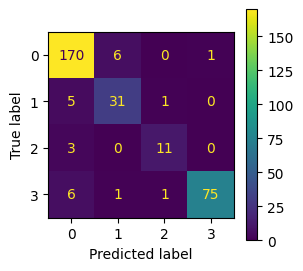

In [13]:
show_metrics(metrics[("poly", 224, "data")])

#### An example of correct classifcation by the model

correct classification by the model: 


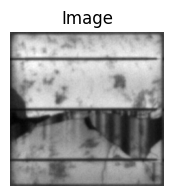

predicted class: certainly defective (100% probability)
actual class: certainly defective (100% probability)


In [14]:
print("correct classification by the model: ")
show_image(correct_classification_poly[0], title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(solar_cell_detector_poly.detect_defect(correct_classification_poly[0]))}\n" +
    f"actual class: {map_label_to_probability(correct_classification_poly[1])}"
)

#### An example of misclassifcation by the model

misclassification by the model: 


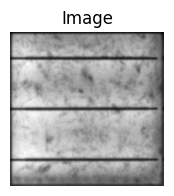

predicted class:  possibly defective (33% probability)
actual class: fully functional (0% probability of being defective)


In [15]:
print("misclassification by the model: ")
show_image(incorrect_classification_poly[0], title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(solar_cell_detector_poly.detect_defect(incorrect_classification_poly[0]))}\n" +
    f"actual class: {map_label_to_probability(incorrect_classification_poly[1])}"
)

### Results

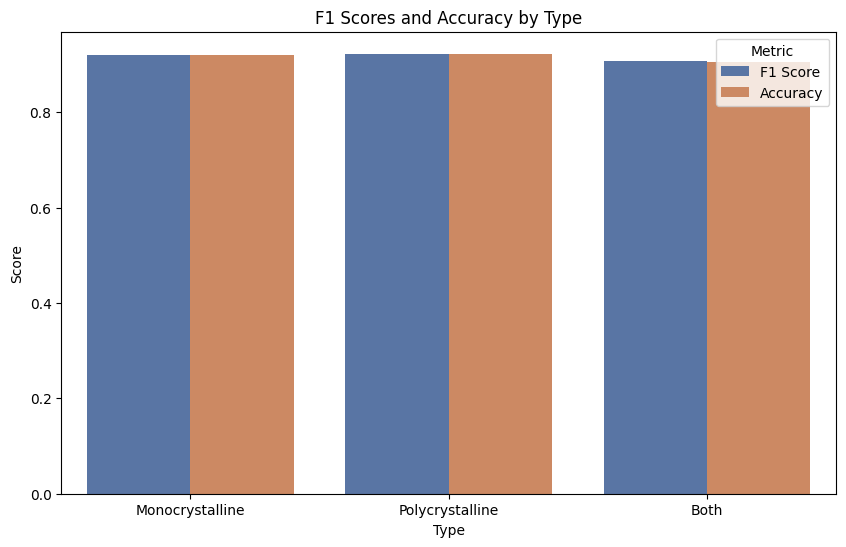

In [16]:
results = {'Monocrystalline':list(metrics[("mono", 224, "data")][:2]), 'Polycrystalline':list(metrics[("poly", 224, "data")][:2]), 'Both':list(metrics[("both", 224, "data")][:2])}
df = pd.DataFrame(results, index=['F1 Score', 'Accuracy']).T.reset_index()
df = df.melt(id_vars='index', value_vars=['F1 Score', 'Accuracy'])
df.rename(columns={'index': 'Type', 'variable': 'Metric', 'value': 'Score'}, inplace=True)

# Plotting the bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Type', y='Score', hue='Metric', data=df, palette = 'deep')
plt.title('F1 Scores and Accuracy by Type')
plt.ylabel('Score')
plt.xlabel('Type')
plt.legend(title='Metric')

# Show the plot
plt.savefig('./plots/mobilenet_plot.png')
plt.show()

## Model: EigenCell Algorithm

EigenCell Algorithm is a derivative implementation of a famous and once a state-of-art method for facial recognition, EigenFace. It was originally introduced by Sirovich and Kirby and used by Matthew Turk and Alex Pentland in face classification.

**Inspired the algorithm:**

The eigenvectors are derived from the covariance matrix of the normalised images over the high-dimensional vector space of solar cell images. The eigencells themselves form a basis set of all images used to construct the covariance matrix. This produces dimension reduction by allowing the smaller set of basis images to represent the original training images. Classification can be achieved by comparing how solar cells are represented by the basis set.

**Process**

1. **Contrast Stretching using HSV:**
Given an image $ I $ and its $V$ channel from the HSV color space, the contrast stretching operation is defined as:
$$
O = \text{clip}\left(\frac{(V - c) \cdot 255}{d - c}, 0, 255\right)
$$
where $ c $ is the minimum value in the V channel, $ d $ is the maximum value in the V channel, and $ O $ is the output image after contrast stretching. The clip operation ensures that values are kept within the range [0, 255].

2. **Gaussian Blur:**
Applying a Gaussian blur to an image $ I $ is achieved by convolving $ I $ with a Gaussian kernel $ G $:
$$
I_{\text{gauss}} = I * G
$$
where $ * $ denotes the convolution operation.

3. **Erosion:**
The erosion of an image $ I $ using a kernel $ K $ is given by:
$$
I_{\text{erode}} = I \ominus K
$$
where $ \ominus $ denotes the erosion operation.

4. **Mean Shifting and Normalization:**
The operation for shifting the mean and normalizing is:
$$
X_{\text{norm}} = \frac{X - \mu}{\| X - \mu \|_{\infty}}
$$
where $ X $ is the matrix of image data, $ \mu $ is the mean of each column in $ X $, and $ \| \cdot \|_{\infty} $ represents the infinity norm (maximum absolute column sum of the matrix).

5. **Eigen Decomposition:**
The covariance matrix $ S $ is computed from the normalized data matrix $ X_{\text{norm}} $ as:
$$
S = \frac{1}{n} X_{\text{norm}}^T X_{\text{norm}}
$$
The eigen decomposition of $ S $ yields eigenvalues $ \lambda_i $ and eigenvectors $ C $, which can be written as:
$$
SC = CD
$$
where $ D $ is a diagonal matrix of eigenvalues $ \lambda_i $ and $ C $ is the corresponding matrix of eigenvectors. To ensure the eigenvectors have unit length, they are normalized as:
$$
C = \frac{C}{\| C \|_2}
$$
where $ \| \cdot \|_2 $ denotes the Euclidean norm.

In [17]:
class EigenCell:
    def __init__(self):
        self.get_data()
        self.le = LabelEncoder().fit(self.train_y)
        self.test_y = self.le.transform(self.test_y)
        self.k = 80

    def get_data(self):
        with open("./data/pickles/preprocessed.pkl", "rb") as f:
            (
                self.train_X,
                self.train_y,
                self.test_X,
                self.test_y,
                self.types,
                self.means,
                self.norms,
                self.k,
                self.C,
                self.D,
            ) = pk.load(f)

    def reduce_dimensionality(self):
        index = self.D.argsort()[::-1]
        D = self.D[index]
        C = self.C[:, index]
        query = (self.test_X - self.means.reshape(-1, 1)) / \
            self.norms.reshape(-1, 1)
        self.Z = C.T @ query
        self.Z[self.k:, :] = 0
        self.p = np.sum(D[: self.k]) / np.sum(D)

    def reconstruct_image(self):
        A = self.C @ self.Z
        A = A * self.norms.reshape(-1, 1)
        self.queries = A + self.means.reshape(-1, 1)

    def process_test_data(self):
        self.reduce_dimensionality()
        self.reconstruct_image()

    def nearest_image(self, query):
        query = query.reshape(query.shape[0], -1)
        norm = np.linalg.norm(query - self.train_X, axis=0)
        index = np.argmin(norm)
        return index

    def predict(self):
        self.process_test_data()
        indices = []
        for i in range(self.test_X.shape[1]):
            indices.append(self.nearest_image(self.queries[:, i]))

        pred = []
        for i in range(self.test_X.shape[1]):
            pred.append(self.train_y[indices[i]])

        self.pred = np.array(pred)
        self.pred = self.le.transform(self.pred)

    def get_metrics(self, test_y, pred):
         return (
        accuracy_score(test_y, pred),
        f1_score(test_y, pred, average="weighted"),
        confusion_matrix(test_y, pred)
    )
         
model = EigenCell()
model.predict()
dimension = (128, 128)

### Monocrystalline Solar Cell

In [18]:
MONO_MASK = model.types=='mono'
pred = model.pred[MONO_MASK]
actual = model.test_y[MONO_MASK]
test = model.test_X[:, MONO_MASK]

In [19]:
accuracy_mono, f1_mono, cm_mono = model.get_metrics(pred, actual)

**Metrics for model**

Accuracy:  0.5335820895522388
F1 score:  0.6432595684941628
Confusion matrix: 


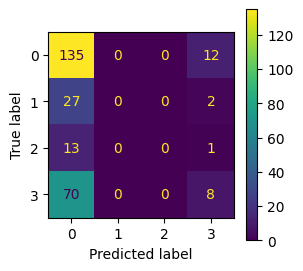

In [20]:
show_metrics((accuracy_mono, f1_mono, cm_mono.T))

In [21]:
label_map = {'0.0': 0, '0.33': 1, '0.66': 2, '1.0': 3}

#### An example of correct classifcation by the model

correct classification by the algorithm: 


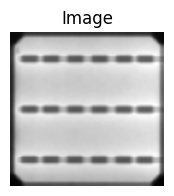

predicted class: fully functional (0% probability of being defective)
actual class: fully functional (0% probability of being defective)


In [22]:
check_idx = 9
actual_image = test[:, check_idx]
correct_idx = model.nearest_image(actual_image)
print("correct classification by the algorithm: ")
show_image(actual_image.reshape(dimension), title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(label_map[model.train_y[correct_idx]])}\n" +
    f"actual class: {map_label_to_probability(actual[check_idx])}"
)

#### An example of misclassifcation by the model

incorrect classification by the algorithm: 


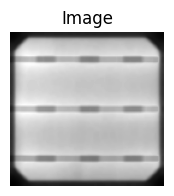

predicted class: certainly defective (100% probability)
actual class: fully functional (0% probability of being defective)


In [23]:
check_idx = 76
actual_image = test[:, check_idx]
incorrect_idx = model.nearest_image(actual_image)
print("incorrect classification by the algorithm: ")
show_image(actual_image.reshape(dimension), title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(label_map[model.train_y[incorrect_idx]])}\n" +
    f"actual class: {map_label_to_probability(actual[check_idx])}"
)

### Polycrystalline Solar Cell

In [24]:
POLY = model.types=='poly'
pred = model.pred[POLY]
actual = model.test_y[POLY]
test = model.test_X[:, POLY]

In [25]:
accuracy_poly, f1_poly, cm_poly = model.get_metrics(pred, actual)

**Metrics for the model**

Accuracy:  0.595360824742268
F1 score:  0.7011001194581065
Confusion matrix: 


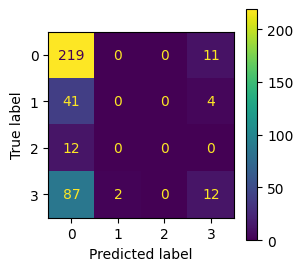

In [26]:
show_metrics((accuracy_poly, f1_poly, cm_poly.T))

#### An example of correct classifcation by the model

incorrect classification by the algorithm: 


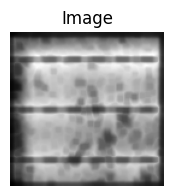

predicted class: fully functional (0% probability of being defective)
actual class: fully functional (0% probability of being defective)


In [27]:
check_idx = 23
actual_image = test[:, check_idx]
incorrect_idx = model.nearest_image(actual_image)
print("incorrect classification by the algorithm: ")
show_image(actual_image.reshape(dimension), title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(label_map[model.train_y[incorrect_idx]])}\n" +
    f"actual class: {map_label_to_probability(actual[check_idx])}"
)

#### An example of misclassifcation by the model

incorrect classification by the algorithm: 


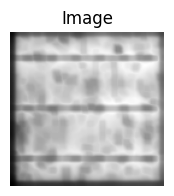

predicted class: certainly defective (100% probability)
actual class: fully functional (0% probability of being defective)


In [28]:
check_idx = 104
actual_image = test[:, check_idx]
incorrect_idx = model.nearest_image(actual_image)
print("incorrect classification by the algorithm: ")
show_image(actual_image.reshape(dimension), title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(label_map[model.train_y[incorrect_idx]])}\n" +
    f"actual class: {map_label_to_probability(actual[check_idx])}"
)

### Both

In [29]:
pred = model.pred
actual = model.test_y
test = model.test_X

In [30]:
accuracy_both, f1_both, cm_both = model.get_metrics(pred, actual)

**Metrics for the model**

Accuracy:  0.5701219512195121
F1 score:  0.677817069425051
Confusion matrix: 


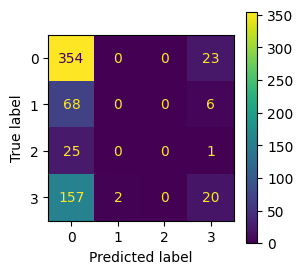

In [31]:
show_metrics((accuracy_both, f1_both, cm_both.T))

#### An example of correct classifcation by the model

correct classification by the algorithm: 


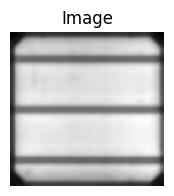

predicted class: certainly defective (100% probability)
actual class: certainly defective (100% probability)


In [32]:
check_idx = 100
actual_image = model.test_X[:, check_idx]
correct_idx = model.nearest_image(actual_image)
print("correct classification by the algorithm: ")
show_image(actual_image.reshape(dimension), title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(label_map[str((int(float(model.train_y[correct_idx])*100))/100)])}\n" +
    f"actual class: {map_label_to_probability(model.test_y[check_idx])}"
)

#### An example of misclassifcation by the model

incorrect classification by the algorithm: 


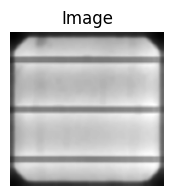

predicted class: certainly defective (100% probability)
actual class: fully functional (0% probability of being defective)


In [33]:
check_idx = 101
actual_image = model.test_X[:, check_idx]
incorrect_idx = model.nearest_image(actual_image)
print("incorrect classification by the algorithm: ")
show_image(actual_image.reshape(dimension), title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(label_map[str((int(float(model.train_y[correct_idx])*100))/100)])}\n" +
    f"actual class: {map_label_to_probability(model.test_y[check_idx])}"
)

### Results

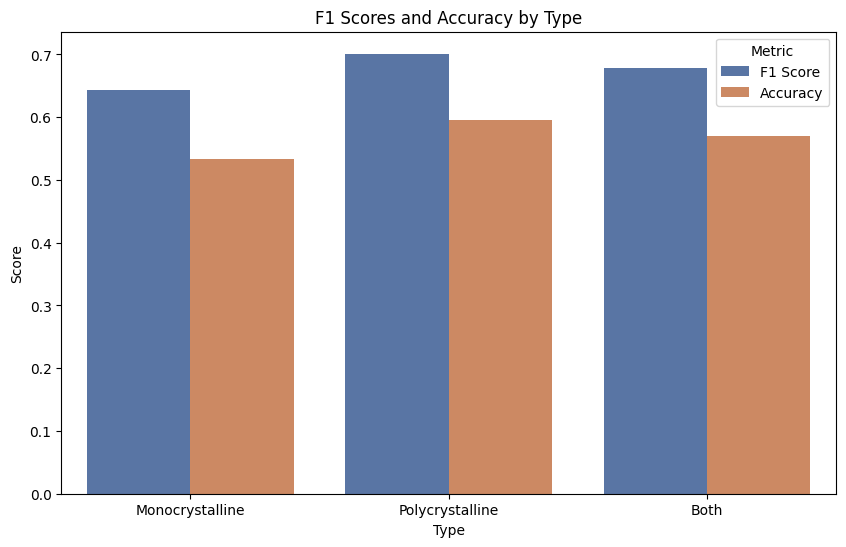

In [34]:
results = {'Monocrystalline':[f1_mono, accuracy_mono], 'Polycrystalline':[f1_poly, accuracy_poly], 'Both':[f1_both, accuracy_both]}
df = pd.DataFrame(results, index=['F1 Score', 'Accuracy']).T.reset_index()
df = df.melt(id_vars='index', value_vars=['F1 Score', 'Accuracy'])
df.rename(columns={'index': 'Type', 'variable': 'Metric', 'value': 'Score'}, inplace=True)

# Plotting the bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Type', y='Score', hue='Metric', data=df, palette = 'deep')
plt.title('F1 Scores and Accuracy by Type')
plt.ylabel('Score')
plt.xlabel('Type')
plt.legend(title='Metric')

# Show the plot
plt.savefig('./plots/eigen_plot.png')
plt.show()

## Model: SIFT & KNN

**Helper Functions**

In [35]:
def evaluate_results(results):
    true_labels = []
    for key, value in results[2].items():
        true_labels.extend([key] * value[1])

    overall_accuracy = accuracy_score(true_labels, results[3])
    conf_matrix = confusion_matrix(true_labels, results[3])
    f1 = f1_score(true_labels, results[3], average='weighted')

    return overall_accuracy, f1, conf_matrix


**COMMENTARY**

In [36]:
def create_sift_feature_database(X_train, Y_train_prob, Y_train_type):
    sift = cv2.SIFT_create()
    desc = []
    sift_database = {
        'fully_functional': [],
        'possibly_defective': [],
        'likely_defective': [],
        'certainly_defective': []
    }

    for img, p, t in tqdm(zip(X_train, Y_train_prob, Y_train_type), total=len(X_train)):
        kp, des = sift.detectAndCompute(img, None)

        if des is not None:
            desc.extend(des)

        if p >= 0.99:
            img_class = 'certainly_defective'
        elif p >= 0.66:
            img_class = 'likely_defective'
        elif p >= 0.30:
            img_class = 'possibly_defective'
        else:
            img_class = 'fully_functional'

        sift_database[img_class].append((des))

    return [desc, sift_database]

**COMMENTARY**

In [37]:
def K_Means_Clustering(k, des):
    K_Means_Clustering = KMeans(n_clusters=k, n_init=10)
    K_Means_Clustering.fit(des)
    k_means_clusters = K_Means_Clustering.cluster_centers_
    return k_means_clusters

**COMMENTARY**

In [38]:
class ImageClassifier:
    def __init__(self):
        pass

    @staticmethod
    def get_ith(img, c):
        itr = 0
        ith = 0
        i = 0

        while i < len(c):
            if i == 0:
                itr = np.linalg.norm(np.subtract(
                    np.array(img), np.array(c[i])))
            else:
                dist = np.linalg.norm(np.subtract(
                    np.array(img), np.array(c[i])))
                if dist < itr:
                    ith = i
                    itr = dist
            i += 1

        return ith

    def classifier(self, x, y):
        feat = {}

        for key, value in tqdm(x.items()):
            class_of_x = []
            for img in tqdm(value):
                hist = np.zeros(len(y))

                if img is not None and all(feature is not None for feature in img):
                    for each_feature in img:
                        ind = self.get_ith(each_feature, y)
                        hist[ind] += 1

                class_of_x.append(hist)
            feat[key] = class_of_x

        return feat

**COMMENTARY**

In [39]:
class CustomKNNClassifier:
    def __init__(self, k=5):
        self.k = k
        self.model = None

    def train(self, train_data):
        X_train = []
        y_train = []

        for key, features_list in train_data.items():
            X_train.extend(features_list)
            y_train.extend([key] * len(features_list))

        self.model = KNeighborsClassifier(n_neighbors=self.k)
        self.model.fit(X_train, y_train)

    def predict(self, test_data):
        true_labels = []
        predicted_labels = []

        for true_label, features_list in test_data.items():
            for features in features_list:
                true_labels.append(true_label)
                predicted_label = self.model.predict([features])[0]
                predicted_labels.append(predicted_label)

        return {
            "true_labels": true_labels,
            "predicted_labels": predicted_labels
        }

**COMMENTARY**

In [40]:
with open('./data/pickles/data.pkl', 'rb') as f:
    images, proba, types = pk.load(f)
    
_images = []
_proba = []
_types = []

for img, prob, typ in zip(images, proba, types):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    min_val, max_val, _, _ = cv2.minMaxLoc(img)
    cs_img = cv2.convertScaleAbs(
        img, alpha=255.0/(max_val - min_val), beta=-min_val * 255.0/(max_val - min_val))
    b_image = cv2.GaussianBlur(cs_img, (5, 5), 0)

    _images.extend([img, b_image])
    _proba.extend([prob] * 2)
    _types.extend([typ] * 2)

images = _images
proba = _proba
types = _types

labels = [f'{p}_{t}' for p, t in zip(proba, types)]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.25, random_state=42, stratify=labels)
Y_train_prob, Y_train_type = zip(*[label.split("_") for label in y_train])
Y_test_prob, Y_test_type = zip(*[label.split("_") for label in y_test])

Y_train_prob = [float(prob) for prob in Y_train_prob]
Y_test_prob = [float(prob) for prob in Y_test_prob]

**COMMENTARY**

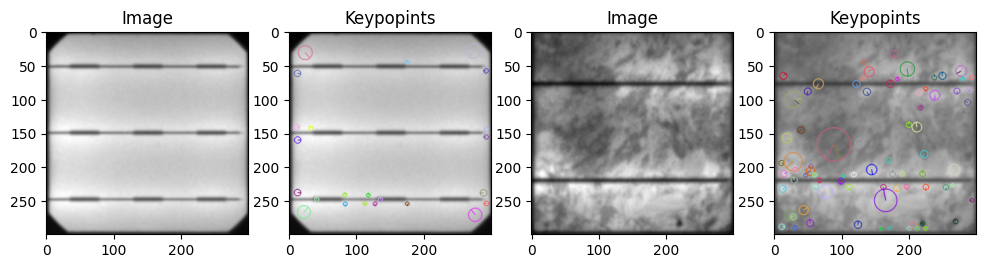

In [42]:
sift = cv2.SIFT_create()
img_1 = X_train[0].copy()
img_2 = X_train[20].copy()

keypoints, descriptors = sift.detectAndCompute(img_1, None)
img_1_kp = cv2.drawKeypoints(
    img_1, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
keypoints, descriptors = sift.detectAndCompute(img_2, None)
img_2_kp = cv2.drawKeypoints(
    img_2, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(12, 6))
plt.subplot(141), plt.imshow(img_1, cmap='gray'), plt.title('Image')
plt.subplot(142), plt.imshow(img_1_kp), plt.title('Keypopints')
plt.subplot(143), plt.imshow(img_2, cmap='gray'), plt.title('Image')
plt.subplot(144), plt.imshow(img_2_kp), plt.title('Keypopints')
plt.savefig('./plots/sift_eda.png')
plt.show()


**COMMENTARY**

In [43]:
sift_features = create_sift_feature_database(
    X_train, Y_train_prob, Y_train_type)

list_of_desc = sift_features[0]
train_features = sift_features[1]

X_test_mono = []
X_test_poly = []
Y_test_prob_mono = []
Y_test_prob_poly = []
Y_test_type_mono = []
Y_test_type_poly = []
for i in range(len(X_test)):
    if Y_test_type[i] == 'mono':
        X_test_mono.append(X_test[i])
        Y_test_prob_mono.append(Y_test_prob[i])
        Y_test_type_mono.append(Y_test_type[i])
    else:
        X_test_poly.append(X_test[i])
        Y_test_prob_poly.append(Y_test_prob[i])
        Y_test_type_poly.append(Y_test_type[i])

  0%|          | 8/3936 [00:00<00:51, 76.54it/s]

100%|██████████| 3936/3936 [00:36<00:00, 107.04it/s]


**COMMENTARY**

In [44]:
Y = (K_Means_Clustering(200, list_of_desc))
test_features = create_sift_feature_database(
    X_test, Y_test_prob, Y_test_type)[1]
test_features_mono = create_sift_feature_database(
    X_test_mono, Y_test_prob_mono, Y_test_type_mono)[1]
test_features_poly = create_sift_feature_database(
    X_test_poly, Y_test_prob_poly, Y_test_type_poly)[1]

100%|██████████| 775/775 [00:07<00:00, 104.12it/s]


**COMMENTARY**

In [45]:
classifier = ImageClassifier()
train = classifier.classifier(train_features, Y)
test = classifier.classifier(test_features, Y)
test_mono = classifier.classifier(test_features_mono, Y)
test_poly = classifier.classifier(test_features_poly, Y)

100%|██████████| 4/4 [01:11<00:00, 17.76s/it]


**COMMENTARY**

In [78]:
knn_classifier = CustomKNNClassifier(k=5)
knn_classifier.train(train)
results = knn_classifier.predict(test)
results_mono = knn_classifier.predict(test_mono)
results_poly = knn_classifier.predict(test_poly)

**COMMENTARY**

In [79]:
correct_indices_mono = [i for i, (true_label, pred_label) in enumerate(zip(
    results_mono["true_labels"], results_mono["predicted_labels"])) if true_label == pred_label]
incorrect_indices_mono = [i for i, (true_label, pred_label) in enumerate(zip(
    results_mono["true_labels"], results_mono["predicted_labels"])) if true_label != pred_label]

correct_indices_poly = [i for i, (true_label, pred_label) in enumerate(zip(
    results_poly["true_labels"], results_poly["predicted_labels"])) if true_label == pred_label]
incorrect_indices_poly = [i for i, (true_label, pred_label) in enumerate(zip(
    results_poly["true_labels"], results_poly["predicted_labels"])) if true_label != pred_label]

correct_indices = [i for i, (true_label, pred_label) in enumerate(zip(
    results["true_labels"], results["predicted_labels"])) if true_label == pred_label]
incorrect_indices = [i for i, (true_label, pred_label) in enumerate(zip(
    results["true_labels"], results["predicted_labels"])) if true_label != pred_label]

label_map = {
    'fully_functional':0,
    'possibly_defective':1,
    'likely_defective':2,
    'certainly_defective':3
}


### Monocrystalline Solar Cell
**Metrics for the model**

Accuracy:  0.7113594040968343
F1 score:  0.6742273427990829
Confusion matrix: 


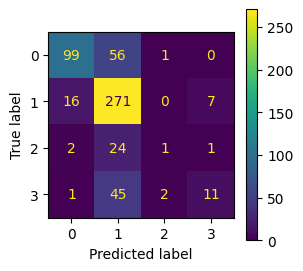

In [81]:
accuracy_mono = accuracy_score(results_mono["true_labels"], results_mono["predicted_labels"])
f1_mono = f1_score(results_mono["true_labels"], results_mono["predicted_labels"], average='weighted')
cm_mono = confusion_matrix(results_mono["true_labels"], results_mono["predicted_labels"])

show_metrics((accuracy_mono, f1_mono, cm_mono))

#### An example of correct classifcation by the model

correct classification by the algorithm: 


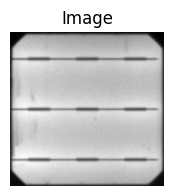

predicted class: likely defective (67% probability)
actual class: likely defective (67% probability)


In [66]:
index = random.choice(correct_indices_mono)
correct_image = X_test_mono[index]
print("correct classification by the algorithm: ")
show_image(correct_image, title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(label_map[results_mono['true_labels'][index]])}\n" +
    f"actual class: {map_label_to_probability(label_map[results_mono['predicted_labels'][index]])}"
)


#### An example of misclassifcation by the model

incorrect classification by the algorithm: 


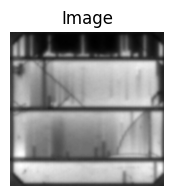

predicted class: fully functional (0% probability of being defective)
actual class: certainly defective (100% probability)


In [65]:
index = random.choice(incorrect_indices_mono)
incorrect_image = X_test_mono[index]
print("incorrect classification by the algorithm: ")
show_image(incorrect_image, title="Image", is_cmap=True)

print(
    f"predicted class: {map_label_to_probability(label_map[results_mono['true_labels'][index]])}\n" +
    f"actual class: {map_label_to_probability(label_map[results_mono['predicted_labels'][index]])}"
)


### Polycrystalline Solar Cell
**Metrics for the model**


Accuracy:  0.7019354838709677
F1 score:  0.6844227104801401
Confusion matrix: 


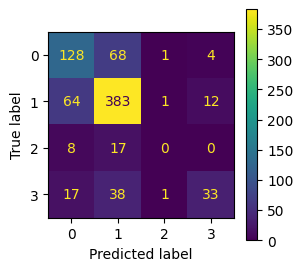

In [82]:
accuracy_poly = accuracy_score(results_poly["true_labels"], results_poly["predicted_labels"])
f1_poly = f1_score(results_poly["true_labels"], results_poly["predicted_labels"], average='weighted')
cm_poly = confusion_matrix(results_poly["true_labels"], results_poly["predicted_labels"])

show_metrics((accuracy_poly, f1_poly, cm_poly))

#### An example of correct classifcation by the model

correct classification by the algorithm: 


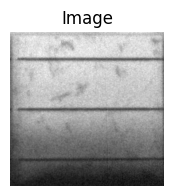

predicted class: fully functional (0% probability of being defective)
actual class: fully functional (0% probability of being defective)


In [67]:
index = random.choice(correct_indices_poly)
correct_image = X_test_poly[index]
print("correct classification by the algorithm: ")
show_image(correct_image, title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(label_map[results_poly['true_labels'][index]])}\n" +
    f"actual class: {map_label_to_probability(label_map[results_poly['predicted_labels'][index]])}"
)


#### An example of misclassifcation by the model

incorrect classification by the algorithm: 


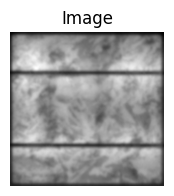

predicted class:  possibly defective (33% probability)
actual class: fully functional (0% probability of being defective)


In [68]:
index = random.choice(incorrect_indices_poly)
incorrect_image = X_test_poly[index]
print("incorrect classification by the algorithm: ")
show_image(incorrect_image, title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(label_map[results_poly['true_labels'][index]])}\n" +
    f"actual class: {map_label_to_probability(label_map[results_poly['predicted_labels'][index]])}"
)


### Both

**Metrics for the model**

Accuracy:  0.7057926829268293
F1 score:  0.6797488190597748
Confusion matrix: 


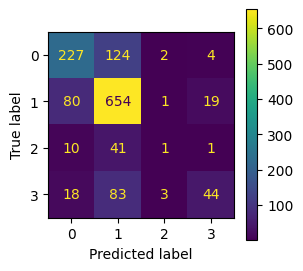

In [80]:
accuracy_both = accuracy_score(results["true_labels"], results["predicted_labels"])
f1_both = f1_score(results["true_labels"], results["predicted_labels"], average='weighted')
cm_both = confusion_matrix(results["true_labels"], results["predicted_labels"])

show_metrics((accuracy_both, f1_both, cm_both))

#### An example of correct classifcation by the model

correct classification by the algorithm: 


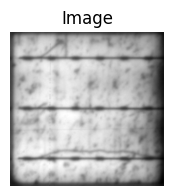

predicted class: certainly defective (100% probability)
actual class: certainly defective (100% probability)


In [69]:
index = random.choice(correct_indices)
correct_image = X_test[index]
print("correct classification by the algorithm: ")
show_image(correct_image, title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(label_map[results['true_labels'][index]])}\n" +
    f"actual class: {map_label_to_probability(label_map[results['predicted_labels'][index]])}"
)


#### An example of misclassifcation by the model

incorrect classification by the algorithm: 


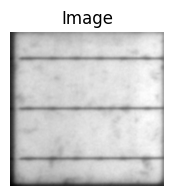

predicted class: fully functional (0% probability of being defective)
actual class: certainly defective (100% probability)


In [70]:
index = random.choice(incorrect_indices)
incorrect_image = X_test[index]
print("incorrect classification by the algorithm: ")
show_image(incorrect_image, title="Image", is_cmap=True)
print(
    f"predicted class: {map_label_to_probability(label_map[results['true_labels'][index]])}\n" +
    f"actual class: {map_label_to_probability(label_map[results['predicted_labels'][index]])}"
)


### Results

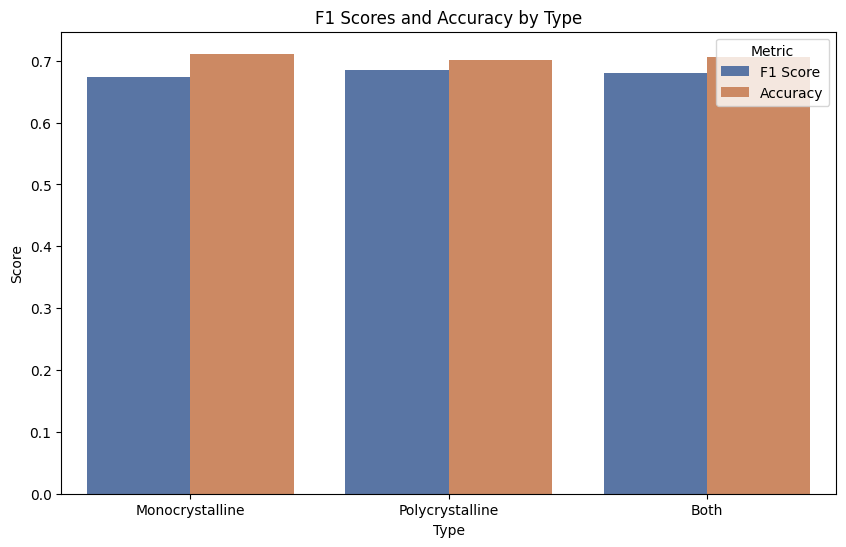

In [72]:
results = {'Monocrystalline':[f1_mono, accuracy_mono], 'Polycrystalline':[f1_poly, accuracy_poly], 'Both':[f1_both, accuracy_both]}
df = pd.DataFrame(results, index=['F1 Score', 'Accuracy']).T.reset_index()
df = df.melt(id_vars='index', value_vars=['F1 Score', 'Accuracy'])
df.rename(columns={'index': 'Type', 'variable': 'Metric', 'value': 'Score'}, inplace=True)

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Type', y='Score', hue='Metric', data=df, palette = 'deep')
plt.title('F1 Scores and Accuracy by Type')
plt.ylabel('Score')
plt.xlabel('Type')
plt.legend(title='Metric')

plt.savefig('./plots/knn_plot.png')
plt.show()